In [165]:
import pandas as pd
import numpy as np

RANDOM_STATE = 404

In [166]:
df = pd.read_csv('data/HAD.csv')
df.head()

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,ONSET_TO_ADMISSION,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING,MRS_90,MRS_90_DICHO
0,70,0,0,3,0,-1,1,0,0,0,...,64,0,96,0,180,0,-1,1,0,0
1,55,0,0,6,0,142,0,3,0,0,...,38,0,104,0,165,0,-1,1,4,1
2,73,0,0,3,0,170,0,0,0,1,...,-1,1,-1,1,-1,1,-1,1,2,0
3,81,0,0,10,0,-1,1,0,0,0,...,69,0,90,0,115,0,-1,1,3,1
4,81,0,1,11,0,-1,1,0,0,0,...,98,0,110,0,120,0,-1,1,0,0


In [167]:
target_feature = 'MRS_90'
y = df.filter([target_feature])
y.to_csv('data/HAD_target.csv', index=False)

#### Because of the warning given while imputing missing values, 'SERUM_GLUCOSE' and 'VALV_HEART' columns are removed due to not having any other entry than '-1' value

In [168]:
df = df.drop(columns={'SERUM_GLUCOSE', 'SERUM_GLUCOSE_MISSING', 'VALV_HEART', 'MRS_90', 'MRS_90_DICHO'}, axis=1)
df.shape

(944, 37)

### Generating missing data based on sklearn imputers

In [169]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# import warnings
# warnings.filterwarnings('ignore')

imputer_df = df.copy()  # Creating a copy of the original DataFrame for imputation

# Initialize IterativeImputer with median strategy for missing values
imp = IterativeImputer(missing_values=-1, initial_strategy='median', random_state=RANDOM_STATE)

# Iterate through columns in the DataFrame
for col in imputer_df.columns:
    # Skip columns ending with '_MISSING'
    if col.endswith('_MISSING'):
        continue
    # Check if there is a corresponding missing flag column
    elif col + "_MISSING" in df.columns:
        # Check if there are missing values to impute
        if (imputer_df[col + "_MISSING"] == 1).any() and (imputer_df[col] == -1).any():
            # Fit imputer on the column and transform the values
            imp.fit(imputer_df[[col]])
            imputer_df[col] = imp.transform(imputer_df[[col]]).ravel()
    else:
        # Check if there are missing values to impute
        if (imputer_df[col] == -1).any():
            # Fit imputer on the column and transform the values
            imp.fit(imputer_df[[col]])
            imputer_df[col] = imp.transform(imputer_df[[col]]).ravel()

# Remove columns related to missingness flags
imputer_df = imputer_df[imputer_df.columns.drop(list(imputer_df.filter(regex='MISSING')))]

# Save the imputed DataFrame to a CSV file
imputer_df.to_csv('data/HAD_no_missingness.csv', index=False)

imputer_df.head()


,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,70.0,0,3.0,148.0,0.0,0.0,1.0,1.0,0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,64.0,96.0,180.0,217.0
1,55.0,0,6.0,142.0,3.0,0.0,1.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,38.0,104.0,165.0,217.0
2,73.0,0,3.0,170.0,0.0,1.0,1.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,90.0,116.0,170.0,217.0
3,81.0,0,10.0,148.0,0.0,0.0,1.0,0.0,1,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,69.0,90.0,115.0,217.0
4,81.0,1,11.0,148.0,0.0,0.0,1.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,98.0,110.0,120.0,217.0


### Using BIC to get the optimal number of components for GMM

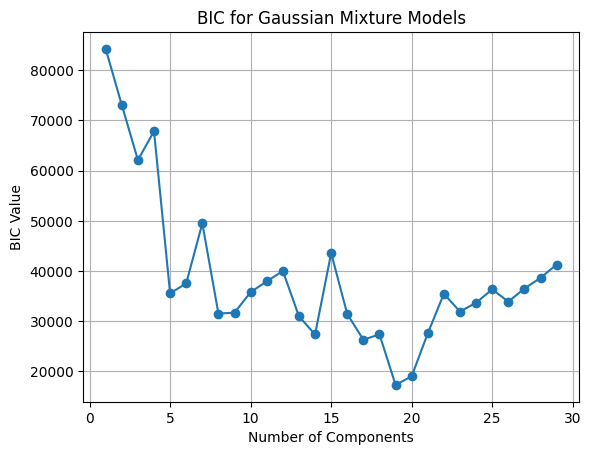

In [170]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def compute_bic(X, n_components_range):
    """
    Computes the Bayesian Information Criterion (BIC) for Gaussian Mixture Models with different numbers of components.
    
    Parameters:
        X (array-like): Input data.
        n_components_range (range): Range of number of components to evaluate.
        
    Returns:
        list: BIC values for each number of components.
    """
    bic = []  # List to store BIC values
    for n_components in n_components_range:
        # Create Gaussian Mixture Model with specified number of components
        gmm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
        gmm.fit(X)  # Fit the model to the data
        bic.append(gmm.bic(X))  # Calculate BIC and add to list
    return bic  # Return list of BIC values

n_components_range = range(1, 30)  # Range of number of components to evaluate

bic_values = compute_bic(imputer_df, n_components_range)  # Compute BIC values

optimal_n_components = n_components_range[np.argmin(bic_values)]  # Determine optimal number of components

# Plotting BIC values
plt.plot(n_components_range, bic_values, marker='o')  # Plot BIC values
plt.xlabel('Number of Components')  # X-axis label
plt.ylabel('BIC Value')  # Y-axis label
plt.title('BIC for Gaussian Mixture Models')  # Title of the plot
plt.grid(True)  # Show grid
plt.show()  # Show plot


### Gaussian Mixture Model fitting

In [171]:
gmm = GaussianMixture(n_components=optimal_n_components, random_state=RANDOM_STATE)
gmm.fit(imputer_df)

GaussianMixture(n_components=19, random_state=404)

### Imputing missing values with the help of conditional GMM

In [172]:
from ConditionalGMM.condGMM import CondGMM
import json

def gmm_generate_samples(n_datapoints=2, n_samples=1000, plot_histograms=False, print_index=False):
    """
    Generate samples using Conditional Gaussian Mixture Model for imputing missing data.

    Args:
        n_datapoints (int/str): Number of data points to consider
        n_samples (int): Number of samples to generate
        plot_histograms (bool): Whether to plot histograms of sampled data
        print_index (bool): Whether to print the index of the current data point
    Returns:
        pd.DataFrame: DataFrame with imputed missing data
    """

    # Create a copy of the DataFrame for data manipulation
    temp_df = df.head(n_datapoints).copy().astype(object)
    # Remove missing flag columns
    temp_df = temp_df[temp_df.columns.drop(list(temp_df.filter(regex='MISSING')))]
        
    for index, row in df.head(n_datapoints).iterrows():
        # Get indices and values of unknown and known features
        unknown_features_indexes, known_features_indexes, known_features_values = get_feature_indices_and_values(temp_df, index, row)
        
        # If all features are known, continue
        if len(unknown_features_indexes) == 0:
            continue
        
        # Initialize CondGMM
        cGMM = CondGMM(gmm.weights_, gmm.means_, gmm.covariances_, known_features_indexes)
        
        # Generate samples using Conditional GMM
        sampled_data = cGMM.rvs(known_features_values, size=n_samples, random_state=RANDOM_STATE)
        
        # Update unknown features with sampled data
        for feature_index in range(len(unknown_features_indexes)):
            temp_df.iloc[index, unknown_features_indexes[feature_index]] = json.dumps([sampled_data[sample_index][feature_index] for sample_index in range(n_samples)])

        # Plot histograms if specified
        if plot_histograms:
            plot_histogram(temp_df, unknown_features_indexes, index, sampled_data)
        
        # Print index if specified, for debugging purposes
        if print_index:
            print(index)
        
    return temp_df
        
def get_feature_indices_and_values(temp_df, index, row):    
    unknown_features_indexes = []  # Initialize list to store indices of unknown features
    
    # Iterate through columns in the DataFrame
    for col in df.columns:
        # Skip columns ending with '_MISSING'
        if col.endswith('_MISSING'):
            continue
        # Check if there is a corresponding missing flag column
        elif col + "_MISSING" in df.columns:
            # Identify unknown features where missing flag is 1 and value is -1
            if row[col + "_MISSING"] == 1 and row[col] == -1:
                unknown_features_indexes.append(temp_df.columns.get_loc(col))  # Add index of feature
        else:
            # Identify unknown features where value is -1
            if row[col] == -1:
                unknown_features_indexes.append(temp_df.columns.get_loc(col))  # Add index of feature
        
    # Find indices of known features
    known_features_indexes = list(set(range(temp_df.shape[1])) - set(unknown_features_indexes))
    
    # Extract values of known features for the given row
    known_features_values = temp_df.iloc[index, known_features_indexes]
    
    return unknown_features_indexes, known_features_indexes, known_features_values  # Return indices and values

def plot_histogram(temp_df, unknown_features_indexes, index, sampled_data, n_bins=20):
    # Create subplots based on the number of unknown features
    fig, axs = plt.subplots(sampled_data.shape[1], 1, figsize=(8, len(unknown_features_indexes) * 4))

    # Plot histograms for each feature
    plot_features(temp_df, sampled_data, axs, unknown_features_indexes, index, n_bins)

    # Add title and labels to the figure
    fig.suptitle(f'Histograms for index {index}', fontsize=20)  # Title with the index
    fig.text(0.5, 0.04, 'Value', ha='center', fontsize=14)  # X-axis label
    fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)  # Y-axis label
    plt.show()  # Show the figure

    
def plot_features(temp_df, sampled_data, axs, unknown_features_indexes, index, n_bins):
    # Ensure axs is a list for consistency in cases when only one feature is plotted
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    for i in range(sampled_data.shape[1]):
        expected_value = imputer_df.iloc[index, unknown_features_indexes[i]]
        
        # Plot histogram for the feature
        axs[i].hist(sampled_data[:, i], bins=n_bins, alpha=0.5, label='sampled data')
        axs[i].hist(imputer_df[imputer_df.columns[unknown_features_indexes[i]]], bins=n_bins, alpha=0.2, label='marginal data')
        axs[i].set_title(f'{temp_df.columns[unknown_features_indexes[i]]}')
        
        # Add expected value as text on the histogram
        axs[i].text(0.95, 0.95, f'Expected value: {expected_value}', ha='right', va='top', transform=axs[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
        
        axs[i].legend(loc='upper left')

In [173]:
%load_ext autoreload
%autoreload 2

n_datapoints = df.shape[0]
cgmm_df = gmm_generate_samples(n_datapoints=n_datapoints)
cgmm_df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,70,0,3,"[139.73850547617286, 153.14451585759303, 175.4...",0,0,1,1,0,1,...,1,0,0,0,0,"[0.9987884347494146, 0.9993210390393203, 0.999...",64,96,180,"[216.99948068950795, 217.00082843846124, 217.0..."
1,55,0,6,142,3,0,1,1,0,0,...,"[0.41015686055552136, 0.17796839889410995, -0....","[-0.2724006168184472, 0.12434409912134788, 0.5...","[0.0015388088703155401, 9.81758497195698e-05, ...","[-0.1854352802546084, -0.07963609769449245, -0...","[0.1674124745864184, 0.26677824712960546, 0.28...","[0.9993210390393203, 0.9992661571102464, 1.000...",38,104,165,"[217.00168141988226, 217.00052194765706, 217.0..."
2,73,0,3,170,0,1,1,1,0,0,...,"[-0.0006789609606796193, 0.0011835834362721744...","[-0.0012115652505854462, 0.0005219476570572963...","[-0.00017989365307916402, 9.817584971989536e-0...","[0.0008284384612536731, 0.0001801272697955852,...","[-0.0009565037112310291, 0.0001149717885915473...","[1.0016814198822503, 1.000542234696567, 1.0002...","[90.00153880887032, 89.99929006520875, 89.9993...","[115.99927085672788, 116.00158836999633, 116.0...","[170.00033455378085, 170.00075181126036, 170.0...","[216.99971574954472, 217.0004777912453, 216.99..."
3,81,0,10,"[171.69800697763986, 145.56464509776217, 164.6...",0,0,1,0,1,0,...,0,0,0,1,0,"[0.9998201063469209, 1.0015388088703203, 0.999...",69,90,115,"[216.99878843474943, 217.00168141988226, 216.9..."
4,81,1,11,"[174.01582807904822, 154.13727918379283, 151.6...",0,0,1,1,0,0,...,"[0.26144475111866494, -0.29629487094888535, -0...","[-0.34261721306168125, -0.04705989508890837, 0...","[-0.0007291432721264528, 0.0011835834362716288...","[0.27204114480466063, 0.4738914360738711, 0.04...","[-0.1760136065548113, 0.1388352597528556, -0.0...","[1.0016814198822503, 1.0000981758497198, 1.000...",98,110,120,"[217.00153880887032, 217.0001801272698, 216.99..."


### Want to focus on CTA_CS to see how cGMM distributes data

In [177]:
cgmm_CTA_CS_column = cgmm_df['CTA_CS']
cgmm_CTA_CS_column

0      [0.9987884347494146, 0.9993210390393203, 0.999...
1      [0.9993210390393203, 0.9992661571102464, 1.000...
2      [1.0016814198822503, 1.000542234696567, 1.0002...
3      [0.9998201063469209, 1.0015388088703203, 0.999...
4      [1.0016814198822503, 1.0000981758497198, 1.000...
                             ...                        
939    [0.9987884347494146, 0.9993210390393203, 0.999...
940    [0.9987884347494146, 0.9993210390393203, 0.999...
941    [1.0016814198822503, 1.000542234696567, 1.0002...
942                                                    1
943    [0.9987884347494146, 0.9993210390393203, 0.999...
Name: CTA_CS, Length: 944, dtype: object

In [178]:
CTA_CS_column = df['CTA_CS']
CTA_CS_column

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
939   -1
940   -1
941   -1
942    1
943   -1
Name: CTA_CS, Length: 944, dtype: int64

In [181]:
for i, entry in enumerate(cgmm_CTA_CS_column):
    if isinstance(entry, str):
        # Deserialize the string back into an array
        float_array = json.loads(entry)
        # Replace the string entry with the deserialized array
        cgmm_CTA_CS_column[i] = float_array

cgmm_CTA_CS_column

0      [0.9987884347494146, 0.9993210390393203, 0.999...
1      [0.9993210390393203, 0.9992661571102464, 1.000...
2      [1.0016814198822503, 1.000542234696567, 1.0002...
3      [0.9998201063469209, 1.0015388088703203, 0.999...
4      [1.0016814198822503, 1.0000981758497198, 1.000...
                             ...                        
939    [0.9987884347494146, 0.9993210390393203, 0.999...
940    [0.9987884347494146, 0.9993210390393203, 0.999...
941    [1.0016814198822503, 1.000542234696567, 1.0002...
942                                                    1
943    [0.9987884347494146, 0.9993210390393203, 0.999...
Name: CTA_CS, Length: 944, dtype: object

ValueError: setting an array element with a sequence.

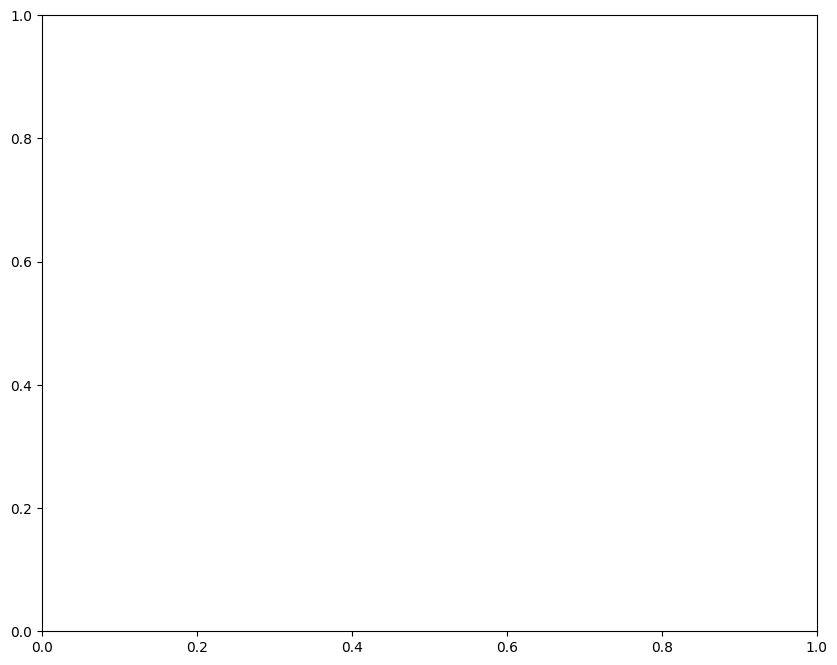

In [180]:
plt.figure(figsize=(10, 8))
plt.scatter(cgmm_CTA_CS_column.values[:n_datapoints], range(n_datapoints), marker='o', color='blue', s=100)
plt.scatter(CTA_CS_column.values[:n_datapoints], range(n_datapoints), marker='^', color='red', s=100)
plt.yticks(range(n_datapoints), range(n_datapoints))
plt.xticks(range(-1, 4, 1), range(-1, 4, 1))
plt.ylabel('Index')
plt.xlabel('Values')
plt.legend(['after GMM', 'before GMM'])
plt.title('CTA_CS values')
plt.grid(True)
plt.show()

plt.savefig('images/CTA_CS.png')